Loading data in chunks...
id        0
cat_0     0
cat_1     0
cat_2     0
cat_3     0
cat_4     0
cat_5     0
cat_6     0
cat_7     0
cat_8     0
cat_9     0
cat_10    0
cat_11    0
cat_12    0
cat_13    0
cat_14    0
cat_15    0
cat_16    0
cat_17    0
cat_18    0
cat_19    0
num_0     0
num_1     0
num_2     0
num_3     0
num_4     0
num_5     0
num_6     0
num_7     0
num_8     0
num_9     0
num_10    0
num_11    0
num_12    0
num_13    0
num_14    0
num_15    0
num_16    0
num_17    0
num_18    0
num_19    0
num_20    0
num_21    0
num_22    0
num_23    0
num_24    0
num_25    0
num_26    0
num_27    0
num_28    0
num_29    0
num_30    0
num_31    0
num_32    0
num_33    0
num_34    0
num_35    0
num_36    0
num_37    0
target    0
dtype: int64
Data Loading Time: 3.40 seconds
Preprocessing data...
Data Preprocessing Time: 7.27 seconds
Starting Bayesian Optimization...
|   iter    |  target   | max_depth | n_esti... | num_le... |
-----------------------------------------------------

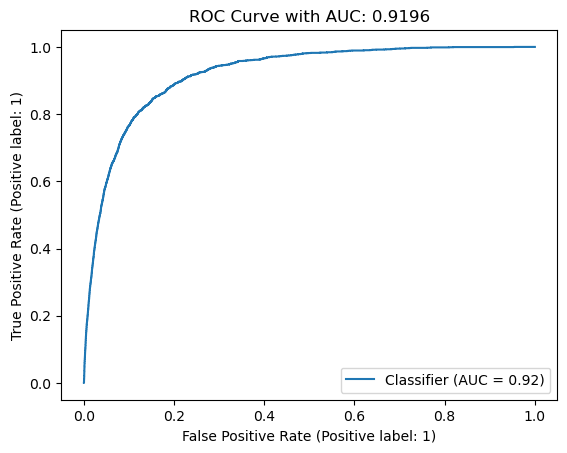

Total Run Time: 221.65 seconds


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, RocCurveDisplay, classification_report, accuracy_score
from lightgbm import LGBMClassifier, early_stopping
from bayes_opt import BayesianOptimization

# Record start time
start_time = time.time()

# Helper function to downcast numerical columns
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype == "int64"]

    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int32)

    return df

# Load data in chunks and downcast
print("Loading data in chunks...")
chunk_size = 100000
chunks = []
for chunk in pd.read_csv('train.csv', chunksize=chunk_size):
    chunk = downcast_dtypes(chunk)
    chunks.append(chunk)
data = pd.concat(chunks, ignore_index=True)

# Check for missing values
print(data.isnull().sum())

# Record data loading time
data_loading_time = time.time()
print(f'Data Loading Time: {data_loading_time - start_time:.2f} seconds')

print("Preprocessing data...")
cat_features = [f'cat_{i}' for i in range(20)]
num_features = [f'num_{i}' for i in range(38)]

# Data preprocessing
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# Split features and target variable
X = data.drop(['id', 'target'], axis=1)
y = data['target']
X_processed = preprocessor.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Record data preprocessing time
data_preprocessing_time = time.time()
print(f'Data Preprocessing Time: {data_preprocessing_time - data_loading_time:.2f} seconds')

# Define the objective function for Bayesian Optimization
def lgb_eval(max_depth, num_leaves, n_estimators):
    params = {
        'max_depth': int(max_depth),
        'num_leaves': int(num_leaves),
        'n_estimators': int(n_estimators),
        'objective': 'binary',
        'metric': 'auc'
    }
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[early_stopping(stopping_rounds=10)])
    y_pred = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred)

# Set the parameter range for Bayesian Optimization
bayes_opt = BayesianOptimization(
    lgb_eval,
    {'max_depth': (5, 20),
     'num_leaves': (20, 100),
     'n_estimators': (50, 300)},
    random_state=42
)

# Run Bayesian Optimization
print("Starting Bayesian Optimization...")
bayes_opt.maximize(init_points=5, n_iter=25)

# Get the best parameters
best_params = bayes_opt.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['n_estimators'] = int(best_params['n_estimators'])

# Train the model with the best parameters and evaluate
print(f"Training the best model with params {best_params}...")
model = LGBMClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
y_pred_binary = (y_pred >= 0.5).astype(int)
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred_binary)
report = classification_report(y_test, y_pred_binary)

print(f'Best Model with params {best_params} has ROC AUC: {roc_auc:.4f}, Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)

# Plot ROC curve
print("Plotting ROC curve...")
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.title(f'ROC Curve with AUC: {roc_auc:.4f}')
plt.show()

# Record end time and calculate total run time
end_time = time.time()
run_time = end_time - start_time
print(f'Total Run Time: {run_time:.2f} seconds')